In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
from scipy.constants import m_e,m_p,m_n

from utils import timeit
from forcefield import LennardJonesPotential, construct_param_matrix
from simpleMD import compute_Hem
import constants

Morse Potential
D*(1 - exp(-a*(-Re + ((-Rx + x)**2 + (-Ry + y)**2 + (-Rz + z)**2)**0.5)))**2
-2*D*a*(1 - exp(-a*(-Re + ((-Rx + x)**2 + (-Ry + y)**2 + (-Rz + z)**2)**0.5)))*(-1.0*Rx + 1.0*x)*exp(-a*(-Re + ((-Rx + x)**2 + (-Ry + y)**2 + (-Rz + z)**2)**0.5))/((-Rx + x)**2 + (-Ry + y)**2 + (-Rz + z)**2)**0.5
Lennard-Jones Potential
4*e*(s**12/((-Rx + x)**2 + (-Ry + y)**2 + (-Rz + z)**2)**6.0 - s**6/((-Rx + x)**2 + (-Ry + y)**2 + (-Rz + z)**2)**3.0)
-4*e*(s**12*(12.0*Rx - 12.0*x)/((-Rx + x)**2 + (-Ry + y)**2 + (-Rz + z)**2)**7.0 - s**6*(6.0*Rx - 6.0*x)/((-Rx + x)**2 + (-Ry + y)**2 + (-Rz + z)**2)**4.0)


The Jacobi of the dipole function has the form:
\begin{align*}
    \begin{bmatrix}
    \partial \mu_x / \partial r_x & \partial \mu_y / \partial r_x & \partial \mu_z / \partial r_x 
    \\
    \partial \mu_x / \partial r_y & \partial \mu_y / \partial r_y & \partial \mu_z / \partial r_y 
    \\
    \partial \mu_x / \partial r_z & \partial \mu_y / \partial r_z & \partial \mu_z / \partial r_z
    \end{bmatrix}
\end{align*}

In [17]:
sm_Rax = sm.symbols("Rax")
sm_Ray = sm.symbols("Ray")
sm_Raz = sm.symbols("Raz")
sm_Ra = [sm_Rax, sm_Ray, sm_Raz]

sm_Rbx = sm.symbols("Rbx")
sm_Rby = sm.symbols("Rby")
sm_Rbz = sm.symbols("Rbz")
sm_Rb = [sm_Rbx, sm_Rby, sm_Rbz]

sm_mu0 = sm.symbols("mu0")
sm_a = sm.symbols("a")
sm_d0 = sm.symbols("d0")
sm_d1 = sm.symbols("d1")
sm_d2 = sm.symbols("d2")
sm_d7 = sm.symbols("d7")

class BaseDipoleFunction:
    def __init__(self):
        
        self.dipole_function = [
            sm.lambdify(
            [sm_Rax, sm_Ray, sm_Raz, sm_Rbx, sm_Rby, sm_Rbz, 
             ] + self.parameters_sm, 
                dipole_exp
        ) for dipole_exp in self.dipole_exp]
        
        self.generate_Jacobi()
        #self.generate_Hessian()

    def generate_Jacobi(self):
        self.Ja_exp = [[],[],[]]
        self.Ja_func = [[],[],[]]

        self.Jb_exp = [[],[],[]]
        self.Jb_func = [[],[],[]]

        for i,Ra in enumerate(sm_Ra):
            for j,dipole_f in enumerate(self.dipole_exp):
                d_mu = sm.diff(dipole_f, Ra)
                self.Ja_exp[i].append(d_mu)
                self.Ja_func[i].append(sm.lambdify(
                    [sm_Rax, sm_Ray, sm_Raz, sm_Rbx, sm_Rby, sm_Rbz, 
                    ]+ self.parameters_sm, d_mu
                ))

                d_mu = sm.diff(dipole_f, sm_Rb[i])
                self.Jb_exp[i].append(d_mu)
                self.Jb_func[i].append(sm.lambdify(
                    [sm_Rax, sm_Ray, sm_Raz, sm_Rbx, sm_Rby, sm_Rbz, 
                    ]+ self.parameters_sm, d_mu
                ))

    def __call__(self, r):
        """
        Note: 
        ra should be the positive particle and 
        rb should be the negative particle
        """
        ra = list(r[0])
        rb = list(r[1])

        args = ra + rb + self.parameters

        result = [dipole_f(*args) for dipole_f in self.dipole_function]
        
        return result

    def gradient(self,r,sign):
        ra = list(r[0])
        rb = list(r[1])
        args = ra + rb + self.parameters

        all_result = []
        for sign_ in sign:
            result = np.zeros((3,3))
            
            if sign_ == "+": 
                J_func = self.Ja_func
            elif sign_ == "-": 
                J_func = self.Jb_func
                
            for i, dmu_dRa in enumerate(J_func):
                for j, dmu_i_dRa in enumerate(dmu_dRa):
                    result[i,j] = dmu_i_dRa(*args)

            all_result.append(result)

        return all_result
    
class GriegorievDipoleFunction(BaseDipoleFunction):
    def __init__(self, mu0, a, d0, d7):

        sm_d = ((sm_Rax - sm_Rbx)**2 + (sm_Ray - sm_Rby)**2 \
             + (sm_Raz - sm_Rbz)**2)**(1/2)
        
        self.parameters = [mu0, a, d0, d7]
        self.parameters_sm = [sm_mu0, sm_a, sm_d0, sm_d7]
        self.dipole_exp = [
            ((sm_Ra[i] - sm_Rb[i])/sm_d) *\
            (sm_mu0 * sm.exp(-sm_a*(sm_d-sm_d0)) - sm_d7/(sm_d**7))
            for i in range(3)
        ]
        
        super().__init__()

dipole_function1 = GriegorievDipoleFunction(mu0=0.0284, a=1.22522, d0=7.10, d7=14200)

print(dipole_function1([[0,0,0],[5,3,2]]))
print(dipole_function1.gradient([[0,0,0],[5,3,2]],["+","-"]))

[-0.03843105719435394, -0.023058634316612366, -0.015372422877741578]
[array([[-0.03803927, -0.02743529, -0.01829019],
       [-0.02743529, -0.00877496, -0.01097411],
       [-0.01829019, -0.01097411,  0.00037014]]), array([[ 0.03803927,  0.02743529,  0.01829019],
       [ 0.02743529,  0.00877496,  0.01097411],
       [ 0.01829019,  0.01097411, -0.00037014]])]


\begin{align*}
\dot{\textbf{C}}_k + i\omega \textbf{C}_k &= \frac{ie^{-i\textbf{k}\cdot \textbf{r}_\mu} }{\omega} \left(I - \frac{\textbf{k} \textbf{k}^T}{|\textbf{k}|} \right) \left( \frac{\partial \mu}{\partial \textbf{r}_{Ar} } \dot{\textbf{r}}_{Ar} + \frac{\partial \mu}{\partial \textbf{r}_{Xe} } \dot{\textbf{r}}_{Xe} \right)
\\
\omega &= ck
\end{align*}

\begin{align*}
    m_{Ar} \ddot{\textbf{r}}_{Ar}^{[\textbf{k}]} &= \sum_{i\neq \textbf{k}} \sum_{j \neq \textbf{k}} \dot{\textbf{r}}_{Ar}^{[i]} \frac{\partial \textbf{A}^{[j]} (\textbf{r}_\mu) }{\partial \textbf{r}^{[\textbf{k}]}_{Ar}}  \frac{\partial \mu^{[j]}}{\partial \textbf{r}_{Ar}^{[i]}} 
    - \sum_{j\neq\textbf{k}} \frac{\partial \textbf{A}^{[j]} (\textbf{r}_\mu) }{\partial t}  \frac{\partial \mu^{[j]}}{\partial \textbf{r}_{Ar}^{[\textbf{k}]}} 
    \\
    m_{Ar} \ddot{\textbf{r}}_{Ar}^{[\textbf{k}1]} 
    &= - \sum_j \frac{\partial \textbf{A}^{[j]} (\textbf{r}_\mu) }{\partial t}  \frac{\partial \mu^{[j]}}{\partial \textbf{r}_{Ar}^{[\textbf{k}1]}} 
    - \sum_{j\neq \textbf{k}} \dot{\textbf{r}}_{Ar}^{[\textbf{k}]} \frac{\partial \textbf{A}^{[j]} (\textbf{r}_\mu) }{\partial \textbf{r}_{Ar}^{[\textbf{k}]}} \frac{\partial \mu^{[j]}}{\partial \textbf{r}_{Ar}^{[\textbf{k}1]}}
\end{align*}

Note that, for simplicity, we currently choose:
\begin{align*}
    \mathbf{x} &= \mathbf{k}
    \\
    \mathbf{y} &= \mathbf{k1}
    \\
    \mathbf{z} &= \mathbf{k2}
\end{align*}

In [123]:
from simpleMD import compute_Hem
from simpleMD import SimpleDynamicModel as OldSimpleDynamicModel


class SimpleDynamicModel:
    def __init__(
            self, k_vec, epsilon, M, dipole_function, dipole_sign, k_const=None, 
            potential=None, coulomb_interaction = False, exclude_EM = False):

        """
        Class of simple model for molecular dyanamic simulation
        for charged particle in EM field
        Args: 
        + q (list/ np.array of int): charge value of particles
        + k_vec (np.array): list of array of k vectors for the EM field
            have shape of n_mode x 3 with n_mode is int >= 1
        + epsilon (np.array): list or array of pairs of polarization vector modes
            for the EM field. Have the shape of n_mode x 2 x 3
        + k_const (float): constant for the Harmonic Oscillator
        + potential (None, MorsePotential, will add more class later):
            'engine' for potential or force computing
        """

        #assert len(q) == len(v) and len(v) == len(r)
        #assert C.shape[0] == k_vec.shape[0]

        if len(k_vec.shape) < 2:
            k_vec = k_vec.reshape(1,3)
        else: 
            assert k_vec.shape[1] == 3
        self.k_vec = k_vec

        if len(epsilon.shape) < 3:
            epsilon = epsilon.reshape(1,2,3)
        else:
            assert epsilon.shape[1] == 2 and epsilon.shape[2] == 3
        self.epsilon = epsilon

        self.k_const = k_const
        self.potential = potential
        self.coulomb_interaction = coulomb_interaction
        self.exclude_EM = exclude_EM

        self.k = []; self.omega = []
        for vec in k_vec:
            k = np.sqrt(vec @ vec.T)
            self.k.append(k)
            self.omega.append( constants.c * k)
            
        self.M = np.tile(M[:,np.newaxis], (1,3) )
        self.dipole_func = dipole_function
        self.dipole_sign = dipole_sign

        # list of unit vector along the wavevector k, hence epsilon_k
        self.epsilon_k = [self.k_vec[i] / self.k[i] for i in range(len(self.k))]

        self.change_of_basis_mat = [
            np.vstack([self.epsilon_k[i], self.epsilon[i]]) for i in range(len(self.k_vec))
        ]

    def dot_C(self, r, v, C):
        """
        Computing partial derivative of C w.r.t. time, a.k.a. C_dot
        Args:
        + r (np.array): list/array of postition of charged particles. Shape: n_particles x 3
        + v (np.array): list/array of velocities of charged particles. Shape: n_particles x 3
        + C (np.array): list/array of pair of modes
        """

        if self.exclude_EM:
            return -1j * self.omega * C

        C_dot = []

        for j, k_vec in enumerate(self.k_vec):

            rk = r #np.einsum("ji,ki->kj",md.change_of_basis_mat[0], r)
            
            mu_grad = self.dipole_func.gradient(rk, self.dipole_sign)
            
            jk = 0
            
            for i, mu_grad_i in enumerate(mu_grad):
                jk += np.exp(-1j * k_vec @ r[i]) * mu_grad_i.T @ v[i] # * (2 * np.pi)**(-1.5)

            jk_transv = (np.eye(3) - np.outer(k_vec, k_vec) / (self.k[j]**2)) @ jk

            proj_jk_transv = np.array([
                jk_transv @ e for e in self.epsilon[j] 
                ])
            
            C_dot.append( -1j * self.omega[j] * C[j] + \
                (2 * np.pi * 1j / self.k[j]) * proj_jk_transv)

        C_dot = np.array(C_dot)
        return C_dot

    def compute_force(self, r, v, C):
        if self.exclude_EM == False:
            F = self.compute_transv_force(r=r, v=v, C=C)
        else: F = 0

        if self.potential is not None:
            F += self.potential.get_force(r)

        if self.k_const:
            F += compute_oscillator_force(r,self.k_const)

        return F
    
    def compute_Hmat_transv(self,r,v):
        K = 0
        for i, vi in enumerate(v):
            K += 0.5 * (self.M[i] * vi) @ vi.T
        return K

    def compute_H(self, r, v, C):
        H_mat = self.compute_Hmat_transv(r=r, v=v)
        H_em = compute_Hem(self.k_vec, C)

        if self.potential is not None:
            H_mat += self.potential.get_potential(r)

        if self.k_const != None:
            H_osci = compute_H_oscillator(r,self.k_const)
        else: H_osci = 0

        return np.sum(H_em), H_mat, H_osci

    def pde_step(self, r, v, C):
        a = self.compute_force(r,v,C) / self.M
        C = self.dot_C(r,v,C)
        r = v
        return r, a, C

    def rk4_step(self, r, v, C, h):
        k1r, k1v, k1c = self.pde_step(
            r=r ,v=v, C=C)
        k2r, k2v, k2c = self.pde_step(
            r=r+k1r*h/2, v=v+k1v*h/2, C=C+k1c*h/2)
        k3r, k3v, k3c = self.pde_step(
            r=r+k2r*h/2, v=v+k2v*h/2, C=C+k2c*h/2)
        k4r, k4v, k4c = self.pde_step(
            r=r+k3r*h, v=v+k3v*h, C=C+k3c*h)

        r = r + (h/6) * (k1r + 2*k2r + 2*k3r + k4r)
        v = v + (h/6) * (k1v + 2*k2v + 2*k3v + k4v)
        C = C + (h/6) * (k1c + 2*k2c + 2*k3c + k4c)

        return r, v, C

    def compute_transv_force(self, r, v, C):
        C_dot = self.dot_C(r,v,C)
        
        ma_list = []

        for j, rj in enumerate(r):
            _ma_ = np.array([0+0j,0+0j,0+0j])
            # sum over all wavevector k
            for l, k_vec in enumerate(self.k_vec):

                rk = np.einsum("ji,ki->kj",md.change_of_basis_mat[l], r)
            
                mu_grad = self.dipole_func.gradient(rk, self.dipole_sign)
                
                # k part
                vk  =  self.epsilon_k[l] @ v[j].T # projection of v on k_vec
                vk1 = self.epsilon[l][0] @ v[j].T # projection of v on epsilon_k1
                vk2 = self.epsilon[l][1] @ v[j].T # projection of v on epsilon_k2
                vkj = [vk1, vk2]

                # C[0] = 0;  C[1] = C_{k1}; C[2] = C_{k2}
                k = self.k[l]
                
                _ma_k = 0
                for m in [1,2]:
                    for n in [1,2]:
                    
                        _ma_k +=   vkj[n-1] * (1j * k * C[l][m-1] * np.exp(1j * k_vec @ rj) \
                                + np.conjugate(1j * k * C[l][m-1] * np.exp(1j * k_vec @ rj)) ) \
                                * mu_grad[j][n][m]
                        
                    foo =           (-C_dot[l][m-1] * np.exp(1j * k_vec @ rj) +  \
                        np.conjugate(-C_dot[l][m-1] * np.exp(1j * k_vec @ rj)) ) \
                        * mu_grad[j][0][m]
                    
                    _ma_k += foo
                    
                _ma_ += _ma_k * self.epsilon_k[l]

                # epsilon part
                for i in [1,2]:
                    _ma_ki = 0
                    for m in [1,2]:
                        _ma_ki +=       (-C_dot[l][m-1] * np.exp(1j * k_vec @ rj) + \
                            np.conjugate(-C_dot[l][m-1] * np.exp(1j * k_vec @ rj)) )\
                            * mu_grad[j][i][m]

                        _ma_ki +=   -vk * (1j * k * C[l][m-1] * np.exp(1j * k_vec @ rj) \
                            + np.conjugate(1j * k * C[l][m-1] * np.exp(1j * k_vec @ rj)) )\
                            * mu_grad[j][i][m]
                       
                    _ma_ += _ma_ki * self.epsilon[l][i-1]

            _ma_ /= constants.c

            ma_list.append(np.real(_ma_))

        return np.array(ma_list)


r_ar = np.array([3,3,3]) # Argon should be negative
r_xe = np.array([0,0,0]) # Xenon should be positive

v_ar = np.array([-1,-1,-1]) * 1e1
v_xe = np.array([1,1,1]) * 1e1

Z_Ar = 18
m_Ar = Z_Ar * (m_p / m_e) + Z_Ar + (40 - Z_Ar) * (m_n / m_e) 
Z_Xe = 54
m_Xe = Z_Xe * (m_p / m_e) + Z_Xe + (131 - Z_Xe) * (m_n / m_e)

n_modes = 3
C = (np.random.rand(n_modes,2) + 1j * np.random.rand(n_modes,2))

k_vec = np.array([
    [1e0/constants.c, 0, 0],
    [1e0/constants.c, 1e0/constants.c, 0],
    [1e0/constants.c, 1e0/constants.c, 1e0/constants.c]
])
epsilon_vec = np.array([
    [[0,1,0], [0,0,1]],
    [[1/np.sqrt(2),-1/np.sqrt(2),0], [0,0,1]],
    [[-np.sqrt(6),-np.sqrt(6),2*np.sqrt(6)], [np.sqrt(2),-np.sqrt(2),0]]
], dtype=np.float64)

assert n_modes == C.shape[0] and n_modes == len(k_vec) and n_modes == len(epsilon_vec)


dipole_func = GriegorievDipoleFunction(
    mu0=0.0124 , a=1.5121, d0=7.10, d7=0
)

pure_epsilon = np.array([0.996, 1.904]) * 1.59360e-3
mixed_epsilon = 1.377 * 1.59360e-3

pure_sigma = np.array([3.41, 4.06]) * (1e-10 / 5.29177e-11)
mixed_sigma = 3.735 * (1e-10 / 5.29177e-11)

epsilon = construct_param_matrix(2,1,pure_epsilon,mixed_epsilon)
sigma = construct_param_matrix(2,1,pure_sigma,mixed_sigma)

lennardj = LennardJonesPotential(
    n_points = 2,
    epsilon = epsilon,
    sigma = sigma,
    L = None)

In [124]:
C

array([[0.11327795+0.90319196j, 0.89487562+0.41181391j],
       [0.6806835 +0.534407j  , 0.88552866+0.46719075j],
       [0.16641149+0.06928338j, 0.01704175+0.33391184j]])

In [125]:
r = np.vstack([r_xe,r_ar])
#r = np.array([r_ar])
v = np.vstack([v_xe,v_ar])
#v = np.array([v_ar])

M = np.array([m_Xe, m_Ar])
#M = np.array([1])

mu_grad = dipole_func.gradient(r,["+","-"])

h = 5e-5

md = SimpleDynamicModel(
    k_vec = k_vec, epsilon = epsilon_vec,potential=lennardj, M = M, 
    dipole_function = dipole_func, dipole_sign = ["+","-"]
)

n_steps = 3000

H_rad_list = []
H_mat_list = []
total_H_list = []
dipole_list = []
steps = []

r_list = []

for i in range(n_steps):
    mu_grad = dipole_func.gradient(r,["+","-"])
    
    r, v, C = md.rk4_step(r,v,C,h)
    
    H_rad, H_mat, _ = md.compute_H(r,v,C)
    total_H = H_rad + H_mat
    dipole = np.array(dipole_func(r))
    dipole = dipole @ dipole.T
    
    steps.append(i)
    H_rad_list.append(H_rad)
    H_mat_list.append(H_mat)
    total_H_list.append(total_H)
    dipole_list.append(dipole)
    
    
    if i % 100 == 0:
        print("Iteration: ", i," Hamiltonian Sum: ",np.sum(md.compute_H(r,v,C)))
    
    if i% 10 == 0:
        r_list.append(r)
    


Iteration:  0  Hamiltonian Sum:  (47145701.54110472+0j)
Iteration:  100  Hamiltonian Sum:  (47145701.54110473+0j)
Iteration:  200  Hamiltonian Sum:  (47145701.54110469+0j)
Iteration:  300  Hamiltonian Sum:  (47145701.54110468+0j)
Iteration:  400  Hamiltonian Sum:  (47145701.5411047+0j)
Iteration:  500  Hamiltonian Sum:  (47145701.5411047+0j)
Iteration:  600  Hamiltonian Sum:  (47145701.54110471+0j)
Iteration:  700  Hamiltonian Sum:  (47145701.54110468+0j)
Iteration:  800  Hamiltonian Sum:  (47145701.541104704+0j)
Iteration:  900  Hamiltonian Sum:  (47145701.541104704+0j)
Iteration:  1000  Hamiltonian Sum:  (47145701.54110469+0j)
Iteration:  1100  Hamiltonian Sum:  (47145701.54110468+0j)
Iteration:  1200  Hamiltonian Sum:  (47145701.54110467+0j)
Iteration:  1300  Hamiltonian Sum:  (47145701.54110461+0j)
Iteration:  1400  Hamiltonian Sum:  (47145701.5411046+0j)
Iteration:  1500  Hamiltonian Sum:  (47145701.54110462+0j)
Iteration:  1600  Hamiltonian Sum:  (47145701.541104645+0j)
Iteration

In [127]:
H_rad_list

[(4.090990811933148e-05+0j),
 (3.739596980476927e-05+0j),
 (3.8118231508931644e-05+0j),
 (4.311009789398286e-05+0j),
 (5.2405178300870335e-05+0j),
 (6.603728790087998e-05+0j),
 (8.404044885344022e-05+0j),
 (0.00010644889147020745+0j),
 (0.00013329705538546712+0j),
 (0.00016461959073288353+0j),
 (0.0002004513593286327+0j),
 (0.0002408274358609521+0j),
 (0.00028578310908614155+0j),
 (0.00033535388303104925+0j),
 (0.00038957547820207914+0j),
 (0.0004484838328007519+0j),
 (0.0005121151039458564+0j),
 (0.0005805056689022263+0j),
 (0.0006536921263161765+0j),
 (0.0007317112974576372+0j),
 (0.0008146002274690168+0j),
 (0.0009023961866208352+0j),
 (0.0009951366715741574+0j),
 (0.0010928594066498712+0j),
 (0.001195602345104837+0j),
 (0.0013034036704149547+0j),
 (0.0014163017975651767+0j),
 (0.0015343353743465084+0j),
 (0.0016575432826600378+0j),
 (0.0017859646398280188+0j),
 (0.001919638799912061+0j),
 (0.0020586053550384516+0j),
 (0.0022029041367306558+0j),
 (0.002352575217249026+0j),
 (0.00250

/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ribeirogroup/miniconda3/envs/polariton_mm/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


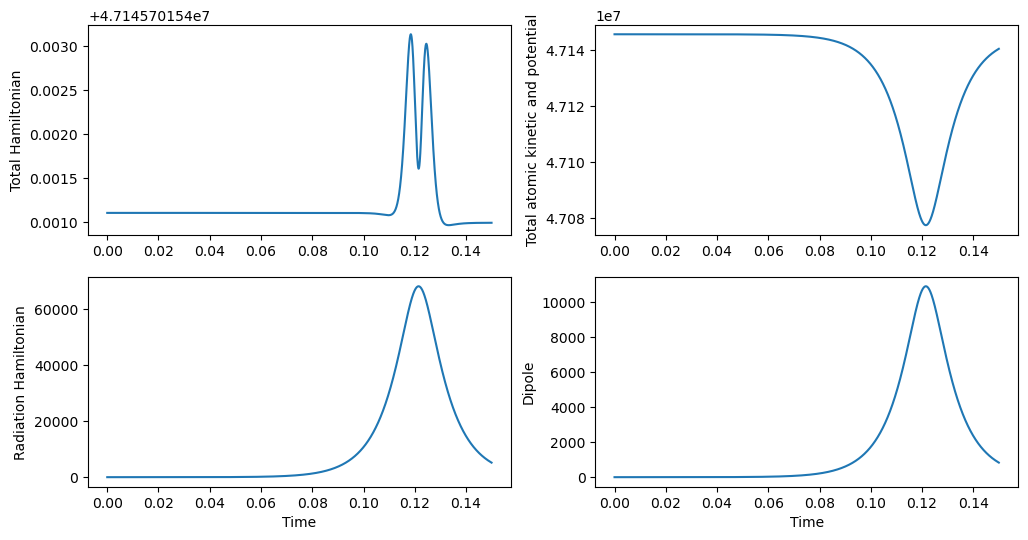

In [126]:
fig,ax =plt.subplots(2,2,figsize = (12,6))
steps_ = np.array(steps)*h

ax[0][0].plot(steps_,total_H_list)
ax[0][0].set_ylabel("Total Hamiltonian")

ax[0][1].plot(steps_,H_mat_list)
ax[0][1].set_ylabel("Total atomic kinetic and potential")

ax[1][0].plot(steps_,H_rad_list)
ax[1][0].set_ylabel("Radiation Hamiltonian")
ax[1][0].set_xlabel("Time")

ax[1][1].plot(steps_,dipole_list)
ax[1][1].set_ylabel("Dipole")
ax[1][1].set_xlabel("Time")

fig.savefig("data.jpeg",dpi=300)

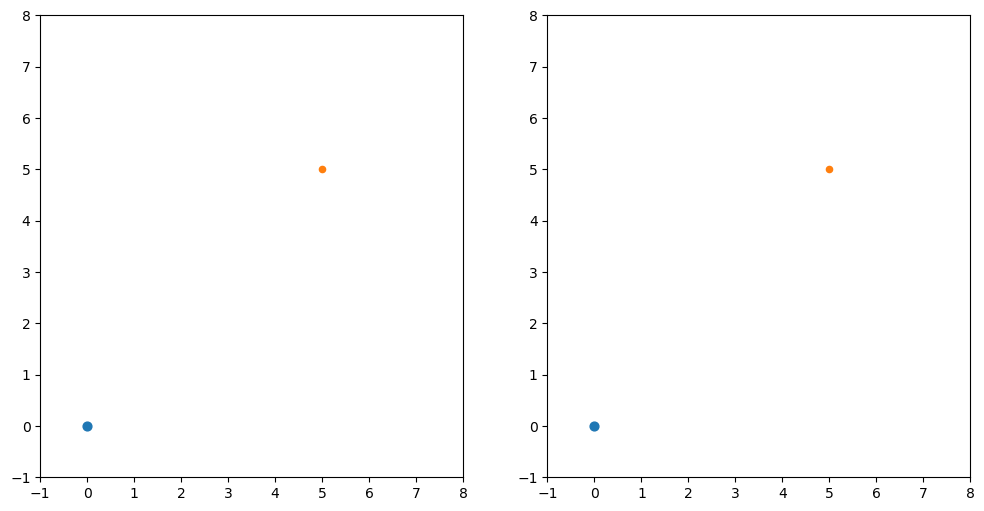

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

%matplotlib inline

fig, ax = plt.subplots(1,2,figsize = (12,6))

scats = []

R = r_list[0]
L = 8

scats.append( ax[0].scatter(R[0, 0], R[0, 1], s = 40) )
scats.append( ax[1].scatter(R[0, 2], R[0, 1], s = 40) )

scats.append( ax[0].scatter(R[1, 0], R[1, 1], s = 20) )
scats.append( ax[1].scatter(R[1, 2], R[1, 1], s = 20) )

ax[0].set_xlim(-1,L)
ax[0].set_ylim(-1,L)
ax[1].set_xlim(-1,L)
ax[1].set_ylim(-1,L)

def animate(i):
    R = r_list[i]

    scats[0].set_offsets(
        np.vstack([R[0, 0], R[0, 1]]).T
    )
    scats[1].set_offsets(
        np.vstack([R[0, 2], R[0, 1]]).T
    )

    scats[2].set_offsets(
        np.vstack([R[1, 0], R[1, 1]]).T
    )
    scats[3].set_offsets(
        np.vstack([R[1, 2], R[1, 1]]).T
    )
    
ani = animation.FuncAnimation(fig, func=animate, frames= len(r_list), interval = 0.1)

#ani.save('result_plot/colliding_in_EM.html', writer=animation.HTMLWriter(fps= 1))

ani.save(filename="result_plot/colliding_in_EM.gif", writer="pillow")

In [62]:
r_list[0][0,1]

0.0004999999999999984